In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBBSSB'
m='TOBS'

In [2]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [5]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       TOBS|USC00421272|    41|[30 D4 80 D4 00 D...|1906.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TOBS|USC00421272|     4|[40 D2 80 D4 80 C...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TOBS|USC00421272|    48|[20 50 20 50 80 5...|1908.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TOBS|USC00421272|    39|[00 7E 80 C9 30 D...|1911.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TOBS|USC00421272|    26|[40 D6 E0 D5 80 D...|1912.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



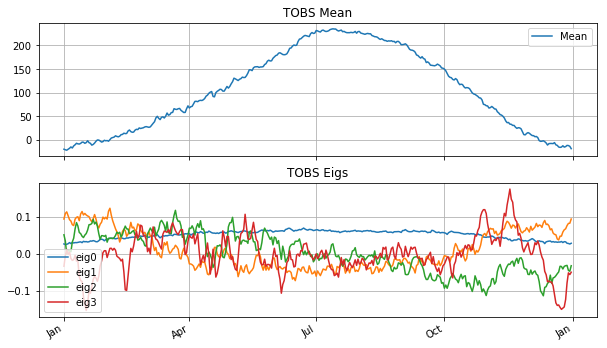

In [6]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i) for i in range(k)])

In [7]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

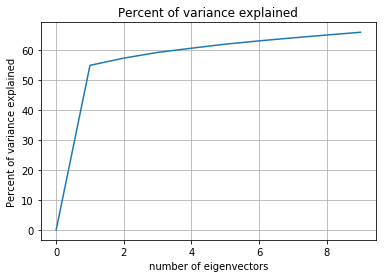

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

In [9]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [10]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1771
after filter 1593


In [11]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(15,3)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for j in range(column_n):
        row=rows[k]
        k+=1
        _title='c0=%3.2f,r0=%3.2f'\
                    %(row['coeff_1'],row['res_1'])
        plot_decomp(row,Mean,v,fig=fig,ax=axes[j],interactive=False,Title=_title)
    return None


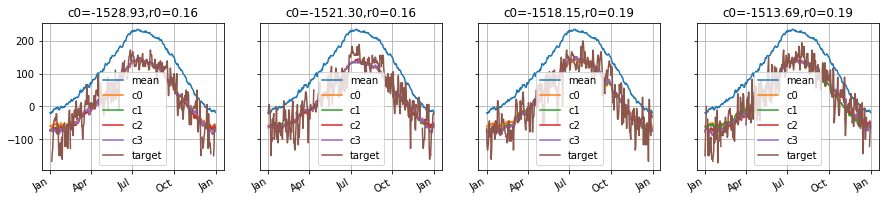

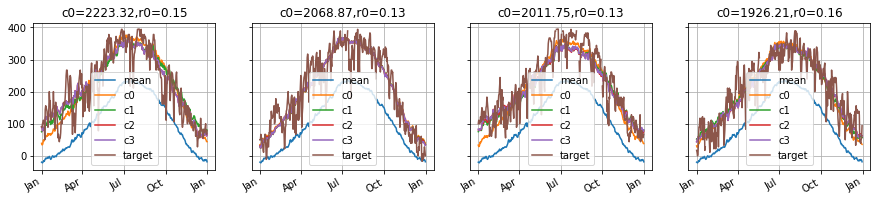

In [44]:
df4=df3.filter(df3.res_1<0.2).sort(df3.coeff_1)
rows=df4.take(4)
plot_recon_grid(rows)
df4=df3.filter(df3.res_1<0.2).sort(df3.coeff_1,ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

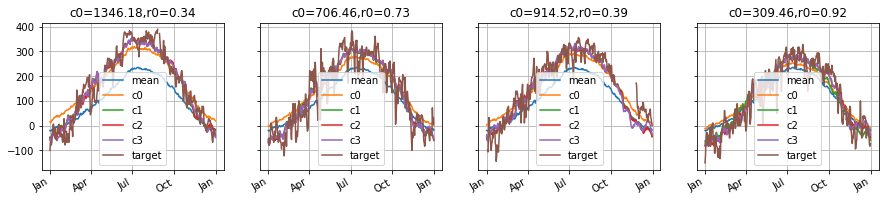

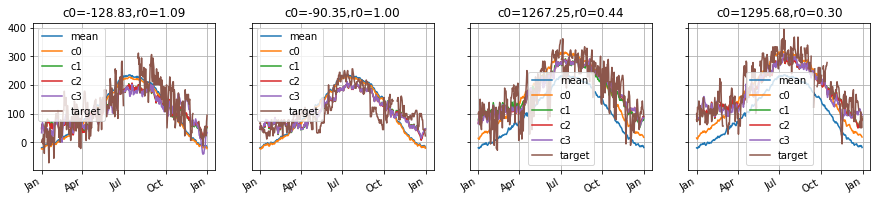

In [46]:
#df4=df3.filter(df3.res_2<0.2).sort(df3.coeff_2)
df4=df3.sort(df3.coeff_2)
rows=df4.take(4)
plot_recon_grid(rows)
#df4=df3.filter(df3.res_2<0.2).sort(df3.coeff_2,ascending=False)
df4=df3.sort(df3.coeff_2,ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

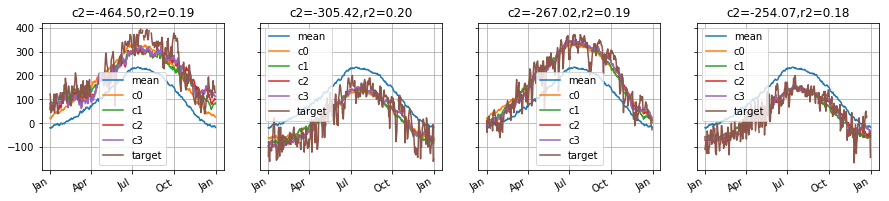

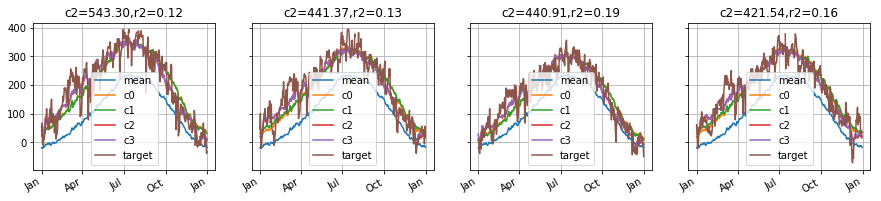

In [40]:
df4=df3.filter(df3.res_3<0.2).sort(df3.coeff_3)
rows=df4.take(4)
plot_recon_grid(rows)
df4=df3.filter(df3.res_3<0.2).sort(df3.coeff_3,ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

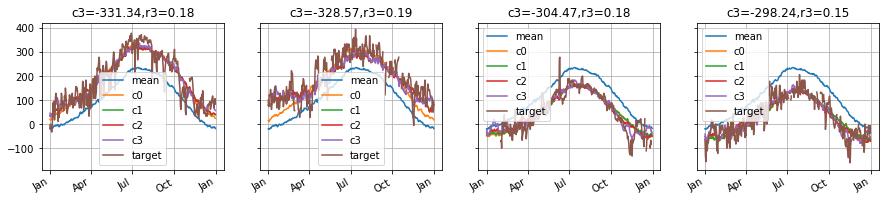

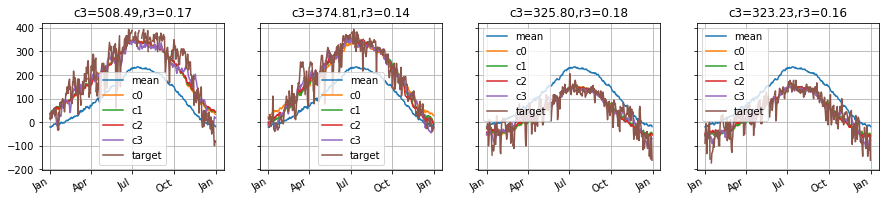

In [38]:
df4=df3.filter(df3.res_4<0.2).sort(df3.coeff_4)
rows=df4.take(4)
plot_recon_grid(rows)
df4=df3.filter(df3.res_4<0.2).sort(df3.coeff_4,ascending=False)
rows=df4.take(4)
plot_recon_grid(rows)

In [96]:
sqlContext.registerDataFrameAsTable(df3,'tobs')
Query1 = "SELECT avg(coeff_1*coeff_1) FROM tobs"
tmp = sqlContext.sql(Query1)
tmp.show()

+------------------------+
|avg((coeff_4 * coeff_4))|
+------------------------+
|       23294.96712671385|
+------------------------+



In [101]:
Query2 = "SELECT avg((coeff_4-coeff_4_y)*(coeff_4-coeff_4_y)) FROM tobs LEFT JOIN (SELECT year, avg(coeff_4) AS coeff_4_y FROM tobs GROUP BY year) AS T2 ON tobs.year=T2.year"
tmp = sqlContext.sql(Query2)
tmp.show()

+----------------------------------------------------+
|avg(((coeff_4 - coeff_4_y) * (coeff_4 - coeff_4_y)))|
+----------------------------------------------------+
|                                   4408.799772735178|
+----------------------------------------------------+



In [104]:
Query3 = "SELECT avg((coeff_4-coeff_4_s)*(coeff_4-coeff_4_s)) FROM tobs LEFT JOIN (SELECT station, avg(coeff_4) AS coeff_4_s FROM tobs GROUP BY station) AS T2 ON tobs.station=T2.station"
tmp = sqlContext.sql(Query3)
tmp.show()

+----------------------------------------------------+
|avg(((coeff_4 - coeff_4_s) * (coeff_4 - coeff_4_s)))|
+----------------------------------------------------+
|                                  22076.452981044422|
+----------------------------------------------------+



residual normalized norm  after mean: 0.158881168434
residual normalized norm  after mean + top eigs: [ 1.08900901  0.87287381  0.85499732  0.80809695]


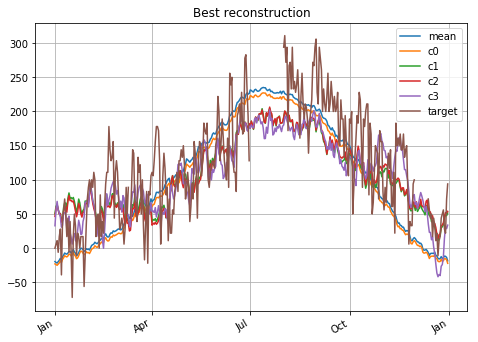

In [47]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

In [28]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=vals
    plot(vals,P)
    title('cumulative distribution of coeff_3')
    ylabel('number of instances')
    xlabel('coeff_3')
    grid()

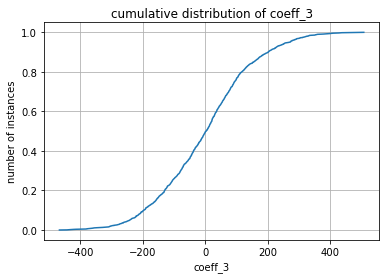

In [29]:
plot_CDF('coeff_4')

In [30]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
print filename
!rm -rf $filename
df3.write.parquet(filename)

../../Data/Weather/decon_SSSBBSSB_TOBS.parquet
